<h1> Evauluation of models </h1>

<b>
I ll run the model to top 100 frames of the towncenter video,which are present in my train dataset and will calculate the metrics for each frame.

<pre>
        Metrics of evaluation: 
            1. MAP
            2. Object-count accuracy.
            3. time-for-prediction.
</pre>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import time

In [5]:
length = 7502

common_path = "/content/drive/MyDrive/Townhall_dataset/OxfordTownCentre"

csv_file = common_path + "/" + os.listdir(common_path)[1]
video_file = common_path + "/" + os.listdir(common_path)[2]

print("Declaring path to raw data :")
print("="*50)
print("common_path :",common_path)
print("csv_file    :",csv_file)
print("video_file  :",video_file)

print()

train = common_path + "/" + "train"
test = common_path + "/" + "test"

#split Ratio
print("Split Ratio :")
print("="*50)
print("train path : {}".format(train))
print("test path  : {}".format(test))
print()
print("-Note")
print("--train : {} that is {} % of the whole data".format(len(os.listdir(train)) , len(os.listdir(train)) / length))
print("--test  : {} that is {} % of the whole data".format(len(os.listdir(test)) , len(os.listdir(test)) / length) )

print()
xml_path = common_path + "/" + "xmls"

#3076 , 3082 , 3086 are missing,so removed it from the train files.
print("="*50)
print("xml_path : {}".format(xml_path))
print()
print("-Note")
print("--No. of total XML files are {} == no. of train files.".format(len(os.listdir(xml_path))))

Declaring path to raw data :
common_path : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre
csv_file    : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/TownCentre-groundtruth.top
video_file  : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/TownCentreXVID.mp4

Split Ratio :
train path : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/train
test path  : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/test

-Note
--train : 3087 that is 0.41149026926153026 % of the whole data
--test  : 4412 that is 0.5881098373766995 % of the whole data

xml_path : /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/xmls

-Note
--No. of total XML files are 3087 == no. of train files.


<h2> Getting the GT of the train dataset </h2>


In [15]:
pip install xmljson

In [16]:
import warnings
warnings.filterwarnings("ignore")
import os
import cv2
import numpy as np
from PIL import Image 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import fromstring
from xmljson import parker
import seaborn as sns
import random

In [32]:
no_of_boxes = []

GT = pd.read_csv(csv_file)

for i in range(0,3090):
  if i == 3086 or i == 3082 or i == 3076:
    continue
  no_of_boxes.append(GT[GT["0.1"] == i ].shape[0])

len(no_of_boxes)

3087

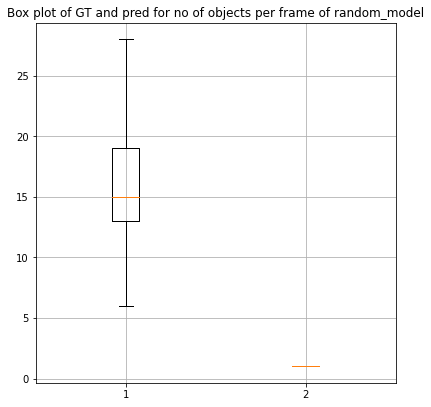

In [33]:
#plotting no_of_boxes.
def give_boxplot(gt , pred , tittle):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1]) 
    data = [gt , pred]
    bp = ax.boxplot(data) 
    plt.title("Box plot of GT and pred for no of objects per frame of {}".format(tittle))
    plt.grid(True)
    plt.show()

#checking the function.
give_boxplot(no_of_boxes , np.ones(3087) , "random_model")

In [31]:
def get_map(maps):
    return sum(maps) / len(maps)

<h3> Getting the initial libraries set </h3>

In [8]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 52889 (delta 0), reused 2 (delta 0), pack-reused 52879
Receiving objects: 100% (52889/52889), 569.31 MiB | 37.68 MiB/s, done.
Resolving deltas: 100% (36217/36217), done.


In [9]:
%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/models/research
Processing /content/models/research
     |████████████████████████████████| 9.0MB 9.3MB/s 
     |████████████████████████████████| 358kB 56.3MB/s 
     |████████████████████████████████| 1.1MB 57.7MB/s 
     |████████████████████████████████| 17.7MB 110kB/s 
     |████████████████████████████████| 153kB 56.4MB/s 
     |████████████████████████████████| 829kB 47.0MB/s 
     |████████████████████████████████| 2.2MB 62.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 645kB 65.3MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 
     |████████████████████████████████| 1.2MB 57.3MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 174kB 60.7MB/s 
     |████████████████████████████████| 706kB 55.6MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 112kB 57.7M

In [10]:
#getting inferenceutils
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2021-03-04 11:56:57--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2021-03-04 11:56:58 (68.8 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



<h2> Evaluation for mobile_net_ssd model. </h2>

In [11]:
#Extracting the trained model.

!unzip /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/mobile_ssd.zip -d /ssd-model/

Archive:  /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/mobile_ssd.zip
   creating: /ssd-model/content/inference_graph/
   creating: /ssd-model/content/inference_graph/checkpoint/
  inflating: /ssd-model/content/inference_graph/checkpoint/ckpt-0.index  
  inflating: /ssd-model/content/inference_graph/checkpoint/checkpoint  
  inflating: /ssd-model/content/inference_graph/checkpoint/ckpt-0.data-00000-of-00001  
   creating: /ssd-model/content/inference_graph/saved_model/
   creating: /ssd-model/content/inference_graph/saved_model/variables/
  inflating: /ssd-model/content/inference_graph/saved_model/variables/variables.index  
  inflating: /ssd-model/content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
   creating: /ssd-model/content/inference_graph/saved_model/assets/
  inflating: /ssd-model/content/inference_graph/saved_model/saved_model.pb  
  inflating: /ssd-model/content/inference_graph/pipeline.config  


In [13]:
#getting the model.

category_index = label_map_util.create_category_index_from_labelmap("/content/label_map.pbtxt", use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/ssd-model/content/inference_graph/saved_model')

In [ ]:
#getting pred_boxes , time_per_frame , maps for the model.

test_images = [train + "/" + i for i in os.listdir(train)]
no_pred_boxes = []
time_per_frame = []
maps = []

for image_name in tqdm(test_images[:100]):
    image_np = load_image_into_numpy_array(image_name)
    start_time = time.time()
    output_dict = run_inference_for_single_image(model, image_np)
    end_time = time.time()
    
    maps.append(get_map(output_dict['detection_scores']))
    no_pred_boxes.append(len(output_dict['detection_scores']))
    time_per_frame.append(end_time - start_time)


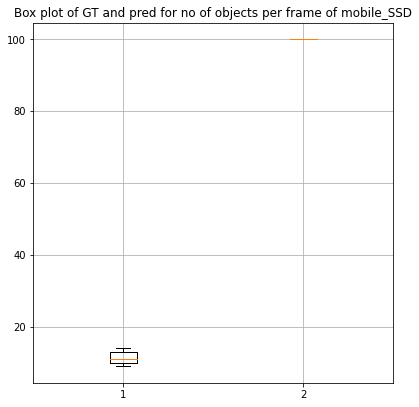

In [25]:
give_boxplot(no_of_boxes[:100] , no_pred_boxes , "mobile_SSD")

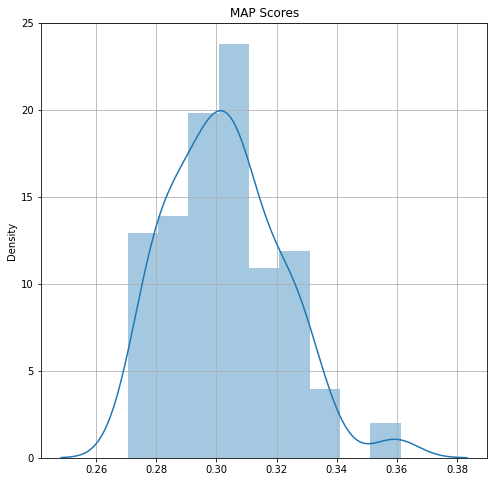

In [ ]:
plt.figure(figsize=(8,8))

plt.title("MAP Scores")
sns.distplot(maps)
plt.grid(True)
plt.show()

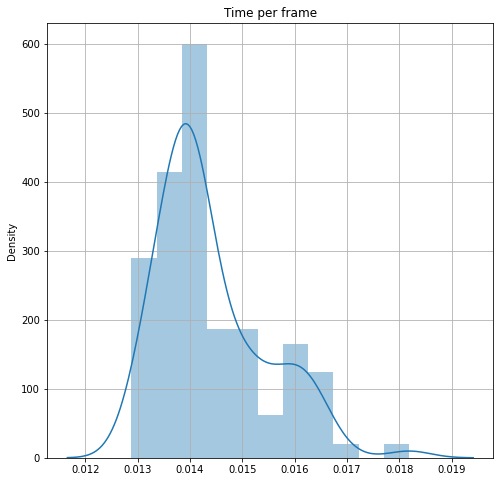

In [ ]:
plt.figure(figsize=(8,8))

plt.title("Time per frame")
sns.distplot(time_per_frame)
plt.grid(True)
plt.show()

<pre>
Observations:
  Mobile net giving the no. of objects in a frame always 100.(solved by NMS)
  MAP of the model is in the range 0.090 to 0.110
  Time per frame: 
    max time : 0.019 sec
    min time : 0.013 sec
</pre>

<h1> Evaluation of centernet </h1>

In [29]:
!unzip /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/centrenet.zip -d /centernet-model/

Archive:  /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/centrenet.zip
   creating: /centernet-model/content/inference_graph/
   creating: /centernet-model/content/inference_graph/checkpoint/
  inflating: /centernet-model/content/inference_graph/checkpoint/ckpt-0.index  
  inflating: /centernet-model/content/inference_graph/checkpoint/checkpoint  
  inflating: /centernet-model/content/inference_graph/checkpoint/ckpt-0.data-00000-of-00001  
   creating: /centernet-model/content/inference_graph/saved_model/
   creating: /centernet-model/content/inference_graph/saved_model/variables/
  inflating: /centernet-model/content/inference_graph/saved_model/variables/variables.index  
  inflating: /centernet-model/content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
   creating: /centernet-model/content/inference_graph/saved_model/assets/
  inflating: /centernet-model/content/inference_graph/saved_model/saved_model.pb  
  inflating: /centernet-model/content/infer

In [30]:

category_index = label_map_util.create_category_index_from_labelmap("/content/label_map.pbtxt", use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/centernet-model/content/inference_graph/saved_model')

In [ ]:
test_images = [train + "/" + i for i in os.listdir(train)]
no_pred_boxes = []
time_per_frame = []
maps = []

for image_name in tqdm(test_images[:100]):
    image_np = load_image_into_numpy_array(image_name)
    start_time = time.time()
    output_dict = run_inference_for_single_image(model, image_np)
    end_time = time.time()
    
    maps.append(get_map(output_dict['detection_scores']))
    no_pred_boxes.append(len(output_dict['detection_scores']))
    time_per_frame.append(end_time - start_time)

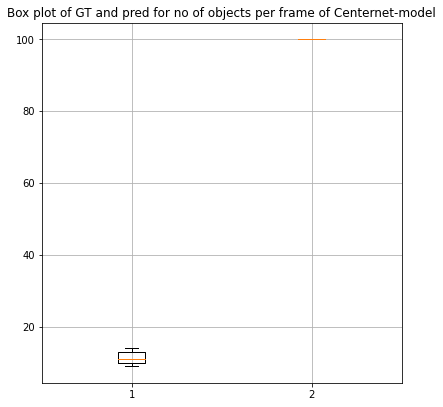

In [32]:
give_boxplot(no_of_boxes[:100] , no_pred_boxes , "Centernet-model")

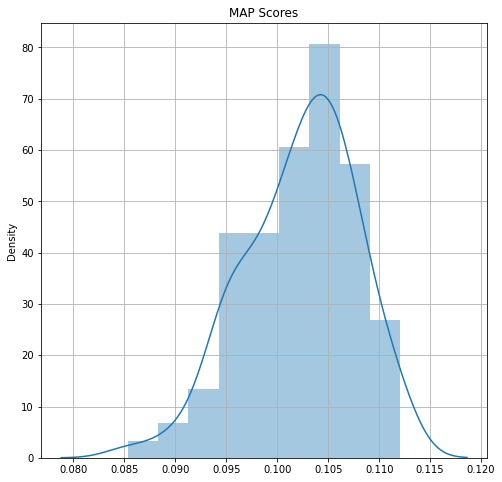

In [ ]:
plt.figure(figsize=(8,8))

plt.title("MAP Scores")
sns.distplot(maps)
plt.grid(True)
plt.show()

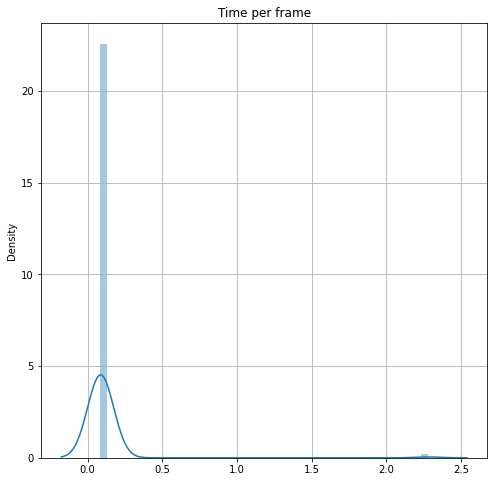

In [ ]:
plt.figure(figsize=(8,8))

plt.title("Time per frame")
sns.distplot(time_per_frame)
plt.grid(True)
plt.show()

<pre>
Observations:
  Mobile net giving the no. of objects in a frame always 100.(solved by NMS)
  MAP of the model is in the range 0.090 to 0.110
  Time per frame: 
    max time : 2.5 sec
    min time : < 0.0 sec
</pre>

<h1> Evaluating YOLO darknet model </h1>

<h4> Getting the trained YOLO network</h4>

In [6]:
!unzip /content/drive/MyDrive/Townhall_dataset/OxfordTownCentre/darknet_trained.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/darknet/data/labels/89_1.png  
  inflating: /content/darknet/data/labels/62_1.png  
  inflating: /content/darknet/data/labels/70_1.png  
  inflating: /content/darknet/data/labels/104_7.png  
  inflating: /content/darknet/data/labels/77_0.png  
  inflating: /content/darknet/data/labels/60_0.png  
  inflating: /content/darknet/data/labels/117_1.png  
  inflating: /content/darknet/data/labels/40_4.png  
  inflating: /content/darknet/data/labels/125_3.png  
  inflating: /content/darknet/data/labels/42_1.png  
  inflating: /content/darknet/data/labels/122_0.png  
  inflating: /content/darknet/data/labels/73_0.png  
  inflating: /content/darknet/data/labels/63_6.png  
  inflating: /content/darknet/data/labels/87_1.png  
  inflating: /content/darknet/data/labels/86_4.png  
  inflating: /content/darknet/data/labels/117_6.png  
  inflating: /content/darknet/data/labels/70_6.png  
  inflating: /content/darknet/data/labels/4

In [9]:
#compiling the model.
%cd /content/darknet 
!make
!chmod +x ./darknet

/content/darknet
make: Nothing to be done for 'all'.


In [ ]:
%cd /content/darknet
!./darknet detector demo data/obj.data cfg/yolov3_custom.cfg backup/yolov3_custom_final.weights TownCentreXVID.mp4 -out_filename result.avi

/content/darknet
Demo
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8 

In [8]:
!/content/darknet/backup/yolov3_custom_final.weights

/content/darknet


In [28]:
#Reference : https://blog.francium.tech/custom-object-training-and-detection-with-yolov3-darknet-and-opencv-41542f2ff44e

#Declaring YOLOV3-Darknet network.

%cd /content/
import cv2
import numpy as np
CONF_THRESH, NMS_THRESH = 0.5, 0.5

# Load the network
net = cv2.dnn.readNetFromDarknet("darknet/cfg/yolov3_custom.cfg", 'darknet/backup/yolov3_custom_final.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the output layer from YOLO
layers = net.getLayerNames()
output_layers = [layers[i[0] - 1] for i in net.getUnconnectedOutLayers()]

/content


In [34]:
# Read and convert the image to blob and perform forward pass to get the bounding boxes with their confidence scores

test_images = [train + "/" + i for i in os.listdir(train)]
no_pred_boxes = []
time_per_frame = []
maps = []

for image_path in tqdm(test_images[:100]): 
  img = cv2.imread(image_path)
  height, width = img.shape[:2]

  blob = cv2.dnn.blobFromImage(img, 0.00392, (608, 608), swapRB=True, crop=False)
  net.setInput(blob)
  layer_outputs = net.forward(output_layers)

  class_ids, confidences, b_boxes = [], [], []

  start_time = start_time = time.time()
  for output in layer_outputs:
      for detection in output:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]

          
          center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')

          x = int(center_x - w / 2)
          y = int(center_y - h / 2)
          temp = [x, y, int(w), int(h)]
          
          b_boxes.append(temp)
          confidences.append(float(confidence))
          class_ids.append(int(class_id))

 
  indices = cv2.dnn.NMSBoxes(b_boxes, confidences, CONF_THRESH, NMS_THRESH).flatten().tolist()

  
  with open("darknet/data/obj.names", "r") as f:
      classes = [line.strip() for line in f.readlines()]
  colors = np.random.uniform(0, 255, size=(len(classes), 3))
  end_time = time.time()
  no_pred_boxes.append(len(indices))
  maps.append(get_map(confidences))
  time_per_frame.append(end_time - start_time)





100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


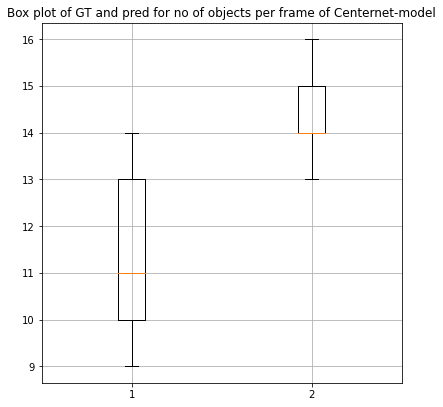

In [35]:
give_boxplot(no_of_boxes[:100] , no_pred_boxes , "Centernet-model")

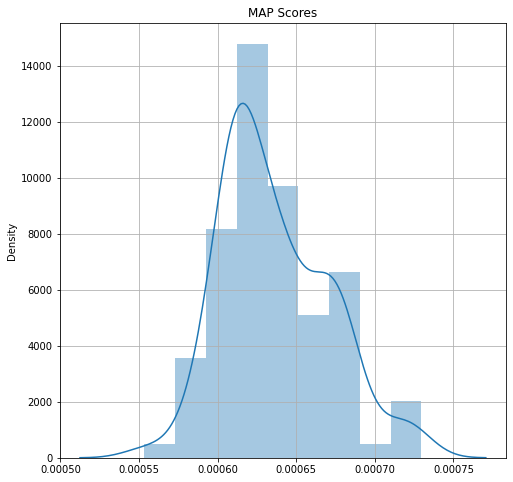

In [36]:
plt.figure(figsize=(8,8))

plt.title("MAP Scores")
sns.distplot(maps)
plt.grid(True)
plt.show()

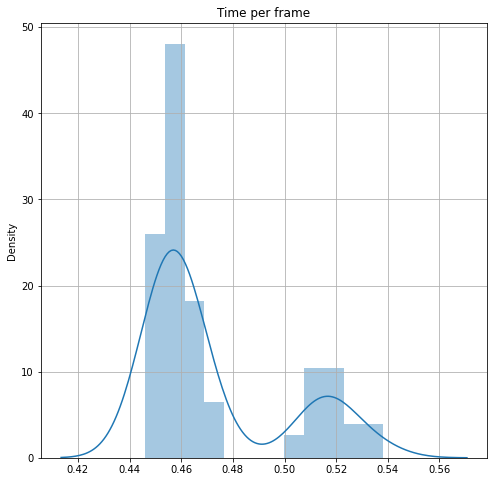

In [37]:
plt.figure(figsize=(8,8))

plt.title("Time per frame")
sns.distplot(time_per_frame)
plt.grid(True)
plt.show()

<pre>
Observations:
  Giving the no. of objects in a frame with 14.(solved by NMS)
  MAP of the model is in the range 0.00055 to 0.00070
  Time per frame: 
    max time : 0.56 sec
    min time : 0.42 sec
</pre>

<pre> 
  Personal-Observations :
    1. Trainning time :
      - mobile-net - 5 mins
      - Center-net - 5 mins
      - darknet-yolo- 5 hours
    
    Performing FLASK api model using YOLO-darknet or Center-net.

</pre>